In [1]:
!pip install transformers torch textstat empath gradio matplotlib SpeechRecognition -q

from transformers import pipeline
import textstat
from empath import Empath
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter
import gradio as gr
import speech_recognition as sr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.0 MB/s eta 0:00:00


In [2]:
# Load sentiment analysis model for Tone / Emotion
sentiment_model = pipeline("sentiment-analysis")

# Lexicon model for topic/semantic analysis (Depth)
lexicon = Empath()

# Speech recognizer for optional audio → text
recognizer = sr.Recognizer()

print("✅ Models loaded: sentiment_model, lexicon, recognizer")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


✅ Models loaded: sentiment_model, lexicon, recognizer


In [3]:
# Optional: convert audio to text (supports .wav best)
def audio_to_text(audio_path: str) -> str:
    """
    Converts a .wav audio file to text using Google Web Speech API.
    Note: Requires internet in Colab.
    """
    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)
        return text
    except Exception as e:
        print("⚠️ Audio transcription failed:", e)
        return ""

def get_top_keywords(text: str, n: int = 5):
    words = re.findall(r'\b[a-zA-Z]{4,}\b', text.lower())
    stopwords = ["this","that","with","from","about","they","have","your","will","then","have","been","their","there"]
    filtered = [w for w in words if w not in stopwords]
    freq = Counter(filtered)
    return [w for w,_ in freq.most_common(n)]

def get_rating(overall: float) -> str:
    if overall >= 85:
        return "🌟 Excellent Mentor"
    elif overall >= 70:
        return "✅ Good Mentor"
    elif overall >= 50:
        return "⚙️ Average Mentor"
    else:
        return "🔁 Needs Improvement"

def generate_insights(scores: dict) -> str:
    if scores["Clarity"] < 60:
        return "Speech clarity can be improved by shortening sentences and using simpler words."
    elif scores["Tone"] < 60:
        return "The tone sounds a bit flat. Adding more energy and variation can help engagement."
    elif scores["Engagement"] < 60:
        return "Consider using more interactive phrases like 'imagine', 'try this', or 'think about'."
    elif scores["Depth"] < 60:
        return "Explanation is correct but could include more examples, analogies, or technical details."
    else:
        return "Strong teaching performance with good clarity, tone, engagement, and depth."


In [4]:
def mentor_scoring_ai(text: str) -> dict:
    """
    Main scoring function: returns scores for Clarity, Tone, Depth, Engagement, Overall.
    """
    text = text.strip()
    if not text:
        return {"Error": "Please provide some input text."}

    # --- Clarity (readability) ---
    try:
        readability = textstat.flesch_reading_ease(text)
    except Exception:
        readability = 60.0  # default if textstat fails
    clarity = min(max(readability, 0), 100)

    # --- Tone / Emotion (sentiment intensity) ---
    sentiment = sentiment_model(text[:512])[0]  # truncate long text for speed
    tone = round(sentiment['score'] * 100, 2)

    # --- Knowledge Depth (topic richness) ---
    topics = lexicon.analyze(text)
    academic_terms = topics.get('education', 0) + topics.get('science', 0) + topics.get('technology', 0)
    depth = min(academic_terms * 10, 100)

    # --- Engagement (interactive language usage) ---
    engagement_keywords = ['imagine', 'try', 'let’s', 'you can', 'think about', 'practice', 'together', 'consider']
    hits = sum(text.lower().count(k) for k in engagement_keywords)
    engagement = min(hits * 15, 100)

    # --- Weighted Overall Score ---
    overall = 0.3 * clarity + 0.3 * tone + 0.2 * depth + 0.2 * engagement

    scores = {
        "Clarity": round(clarity, 2),
        "Tone": round(tone, 2),
        "Depth": round(depth, 2),
        "Engagement": round(engagement, 2),
        "Overall Mentor Score": round(overall, 2)
    }
    return scores


In [5]:
def radar_chart(scores: dict):
    labels = ["Clarity", "Tone", "Depth", "Engagement"]
    values = [scores[l] for l in labels]
    values += values[:1]  # close the loop
    angles = np.linspace(0, 2*np.pi, len(labels)+1)

    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.3)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    plt.title("Mentor Evaluation Radar Chart")
    plt.show()


Scores: {'Clarity': 52.93, 'Tone': 99.64, 'Depth': 10.0, 'Engagement': 45, 'Overall Mentor Score': 56.77}


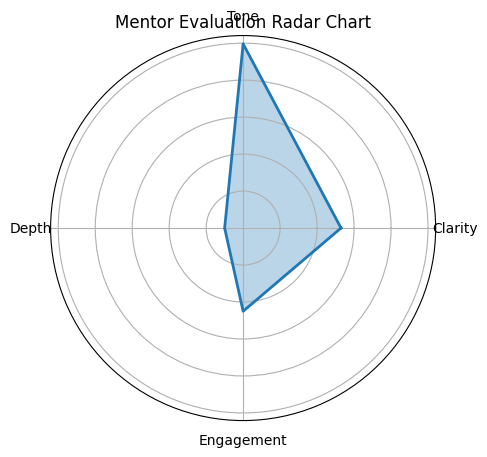

🏅 Rating: ⚙️ Average Mentor
💬 Insight: Speech clarity can be improved by shortening sentences and using simpler words.
🗝️ Top Keywords: sunlight, into, today, explore, photosynthesis


In [6]:
sample_text = """
Today we’ll explore how photosynthesis works. Imagine leaves as solar panels converting sunlight into energy.
You can think of chlorophyll as the pigment that absorbs light. Let’s understand how CO2 and sunlight turn into glucose.
"""

scores = mentor_scoring_ai(sample_text)
print("Scores:", scores)
radar_chart(scores)
print("🏅 Rating:", get_rating(scores["Overall Mentor Score"]))
print("💬 Insight:", generate_insights(scores))
print("🗝️ Top Keywords:", ", ".join(get_top_keywords(sample_text)))


In [ ]:
def mentor_scoring_interface(text, audio_file):
    # If audio is uploaded, convert it to text and append
    if audio_file is not None:
        audio_path = audio_file.name  # Gradio gives a temp file object
        audio_text = audio_to_text(audio_path)
        if audio_text:
            text = (text or "") + "\n" + audio_text

    scores = mentor_scoring_ai(text or "")
    if "Error" in scores:
        return "⚠️ Please paste text or upload a valid audio clip."

    rating = get_rating(scores["Overall Mentor Score"])
    insight = generate_insights(scores)
    keywords = ", ".join(get_top_keywords(text))

    feedback = (
        f"🧠 **Overall Mentor Score:** {scores['Overall Mentor Score']} / 100\n\n"
        f"✨ Clarity: {scores['Clarity']}%\n"
        f"🎙️ Tone & Emotion: {scores['Tone']}%\n"
        f"📚 Knowledge Depth: {scores['Depth']}%\n"
        f"🔥 Engagement: {scores['Engagement']}%\n\n"
        f"🏅 **Rating:** {rating}\n"
        f"💬 **AI Insight:** {insight}\n"
        f"🗝️ **Top Keywords:** {keywords if keywords else 'Not enough content'}\n\n"
        f"*(Prototype – Mentor Scoring AI for UpSkill India Challenge)*"
    )
    return feedback

demo = gr.Interface(
    fn=mentor_scoring_interface,
    inputs=[
        gr.Textbox(lines=8, label="Paste Mentor Transcript (optional if you upload audio)"),
        gr.Audio(type="filepath", label="Upload Mentor Audio (.wav recommended, optional)")
    ],
    outputs=gr.Markdown(label="Mentor Evaluation Report"),
    title="Mentor Scoring AI – Prototype (Round 2)",
    description="Evaluates teaching quality based on clarity, tone, depth, and engagement from mentor transcripts or audio.",
    article="Developed by Sameer Mishra – IIT Madras | Team NeuroLearn",
    theme="soft"
)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5849f9800788b74b92.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
